In [1]:
import jax
import jax.lax as lax
import jax.numpy as jnp
from jax.random import key, split, uniform

import matplotlib.pyplot as plt


jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=3)

# Parameter inference for HMMs

In this notebook, we explore the parameter inference of hidden Markov models using the Baum-Welch algorithm.
First we have to define the problem.

In [2]:
seed = 0
n = 4 # Number of states
m = 3 # Number of observations
# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.95 * jnp.eye(n, dtype=jnp.float64)
T = T + 0.05 * jnp.eye(n, k=1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(-jnp.linspace(0, 10, n, dtype=jnp.float64))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = jnp.zeros((n, m), dtype=jnp.float64)
O = O * jnp.linspace(0, 1, n)[:, None]
O = O.at[0, 0].set(1.0)
for s in range(n):
    O = O.at[s].set(jnp.exp(- ((jnp.arange(m) - (s*m) / n)**2)/(s + 1)))
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])

T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


The above code defines the true underlying HMM parameters for $T$, $O$ and $\mu$. They look like this: 

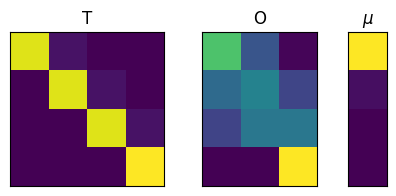

In [3]:
fig, ax = plt.subplots(1, 3, width_ratios=(n, m, 1))
fig.set_size_inches(5,2)
ax[0].imshow(T)
ax[0].set_title("T")
ax[1].imshow(O)
ax[1].set_title("O")
ax[2].imshow(mu[:,None])
ax[2].set_title(r"$\mu$")
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()

We are now ready to use our parameters to generate a set of sequences which we will use to train our HMM.

In [4]:
from generation import generate_sequence

n_sequences = 10_000
len_sequence = 100
rng_key, *sequence_keys = split(key(seed), 1 + n_sequences)

generate = jax.jit(lambda _key: generate_sequence(_key, T, O, mu, len_sequence))

states, observations = jax.vmap(generate)(jnp.array(sequence_keys))

print("states.shape =", states.shape)

states.shape = (10000, 100)


We can compute some statistics for our sampled sequences:

1. average state at each iteration
2. mean likelihood of the sequences generated
3. distribution of observations at each time step
4. distribution of hidden states at each time steps

Note that the likelihood quickly approaches 0 as the sequence becomes longer. The final plot shows the distributions of different states over time. Towards the end, it is highly likely to be in the final state, from where no other transitions are possible.

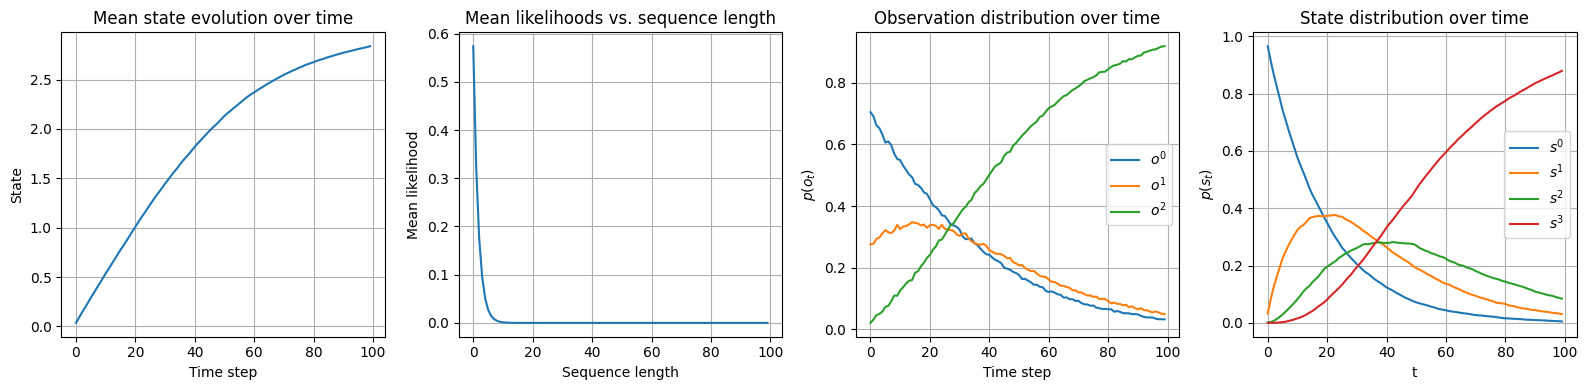

In [5]:
from likelihoods import likelihood

def plot_stats(states, observations):
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(16,4)

    ax[0].set_title("Mean state evolution over time")
    ax[0].plot(jnp.mean(states, axis=0))
    ax[0].grid()
    ax[0].set_xlabel("Time step")
    ax[0].set_ylabel("State")

    _, likelihoods = jax.vmap(lambda obs_seq: likelihood(obs_seq, T, O, mu, return_stats=True))(observations)
    ax[1].set_title("Mean likelihoods vs. sequence length")
    ax[1].plot(jnp.mean(likelihoods, axis=0))
    ax[1].set_xlabel("Sequence length")
    ax[1].set_ylabel("Mean likelihood")
    ax[1].grid()

    obs_distribution = lax.map(lambda o: jnp.count_nonzero(observations == o, axis=0), jnp.arange(m)) / observations.shape[0]
    for k, obs_prob in enumerate(obs_distribution):
        ax[2].plot(obs_prob, label=f"$o^{k}$")
    ax[2].set_title("Observation distribution over time")
    ax[2].grid()
    ax[2].legend()
    ax[2].set_xlabel("Time step")
    ax[2].set_ylabel("$p(o_t)$")

    state_distribution = lax.map(lambda s: jnp.count_nonzero(states == s, axis=0), jnp.arange(n)) / states.shape[0]
    for k, state_prob in enumerate(state_distribution):
        ax[3].plot(state_prob, label=f"$s^{k}$")

    ax[3].set_title("State distribution over time")
    ax[3].set_xlabel("t")
    ax[3].set_ylabel("$p(s_t)$")
    ax[3].grid()
    ax[3].legend()

    plt.tight_layout()
    plt.show()

plot_stats(states, observations)

# The forward backward algorithm

Through the forward backward algorithm, we can compute in an iterative way the conditional probabilities

$$ \mathbb{P}(s_t = k | o_{1:t}, T, O, \mu)$$

and 

$$ \mathbb{P}(o_{t+1:N} | s_t = k, T, O ,\mu)$$

These probabilities then play a major role in finding a parameter estimate for $O$. We now illustrate the results of forward backward.

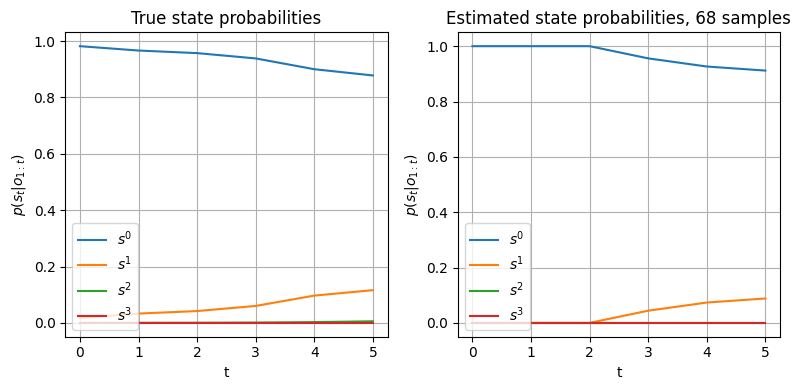

In [6]:
from inference import forward_backward

test_length = 6
test_sequence = observations[0, :test_length]

gamma, xi = forward_backward(test_sequence, T, O , mu)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8,4)

for k, row in enumerate((gamma / jnp.sum(gamma, axis=-1)[:, None]).T):
    ax[0].plot(row, label=f"$s^{k}$")
ax[0].set_title("True state probabilities")

identical_indices = jnp.all(observations[:, :test_length] == test_sequence, axis=-1)
identical_samples = jnp.sum(identical_indices)

filtered_states = states[identical_indices]

state_distr = lax.map(lambda s: jnp.count_nonzero(filtered_states == s, axis=0), jnp.arange(n)) / filtered_states.shape[0]

for k, row in enumerate(state_distr):
    ax[1].plot(row[:test_length], label=f"$s^{k}$")
ax[1].set_title("Estimated state probabilities" + f", {len(filtered_states)} samples")

for k in (0,1):
    ax[k].set_xlabel("t")
    ax[k].set_ylabel("$p(s_t | o_{1:t})$")
    ax[k].grid()
    ax[k].legend(loc="lower left")

plt.tight_layout()
plt.show()

We can now try to estimate the parameters using the Baum-Welch algorithm. In order for the algorithm to work, we have to restrict the structure of the transition matrix.

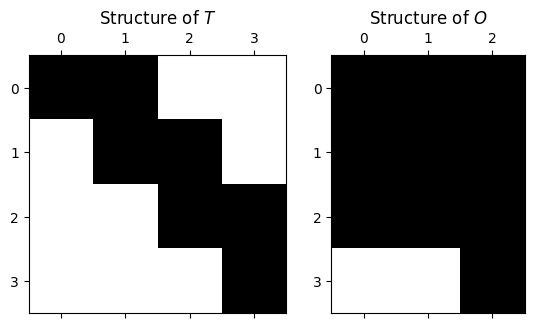

In [7]:
T_structure = jnp.tril(jnp.triu(jnp.ones_like(T, dtype=jnp.float64)), 1)
O_structure = jnp.ones_like(O, dtype=jnp.float64)
O_structure = O_structure.at[n-1, :m-1].set(0)

fig, ax = plt.subplots(1,2, width_ratios=(n, m))
ax[0].spy(T_structure)
ax[0].set_title("Structure of $T$")
ax[1].spy(O_structure)
ax[1].set_title("Structure of $O$")
plt.show()

In [71]:
from functools import partial
from inference import baum_welch, baum_welch_log

@partial(jax.jit, static_argnames=["batch_size", "parallel_batches"])
def fit_parallel(
    rng_key,
    obs, 
    T_structure, 
    O_structure, 
    mu, 
    batch_size: int = 25, 
    parallel_batches: int = 20_000):

    batch_key, *key_arr = split(rng_key, 1 + parallel_batches)
    train_batches = jax.random.choice(batch_key, len(observations), (parallel_batches, batch_size), replace=True)

    def fit(rng_key, batch):
        key_T, key_O = split(rng_key)

        _T = uniform(key_T, T_structure.shape) * T_structure
        _O = uniform(key_O, O_structure.shape) * O_structure

        _T = _T / jnp.sum(_T, axis=1)[:, None]
        _O = _O / jnp.sum(_O, axis=1)[:, None]

        # return baum_welch(batch, _T, _O, mu, epsilon=1e-3)
        return baum_welch_log(batch, _T, _O, mu)


    _T_arr, _O_arr = jax.vmap(fit, in_axes=(0, 0))(jnp.array(key_arr), obs[train_batches])
    
    return _T_arr, _O_arr

n_train = 200
T_arr, O_arr = fit_parallel(key(0), observations[:n_train], T_structure, O_structure,  mu)
print("Precision\nT:", T_arr.dtype, "\nO:", O_arr.dtype)

Precision
T: float64 
O: float64


### Post processing

After running the algorithm many times, we can then try to make sense of its results. The simplest way is to just take the mean of the results and normalize it.

In [72]:
from likelihoods import log_likelihood
from logsumexp import logsumexp

T_mean = jnp.nanmean(T_arr, axis=0)
O_mean = jnp.nanmean(O_arr, axis=0)

T_mean = T_mean / jnp.sum(T_mean, axis=-1)[:,None]
O_mean = O_mean / jnp.sum(O_mean, axis=-1)[:,None]

A slightly more clever way is to weight the sum by the log likelihoods achieved by the parameters

In [73]:
logits = jnp.zeros(len(T_arr))

for k in range(len(T_arr)):
    logits = logits.at[k].set(
        logsumexp(jax.vmap(lambda _obs: log_likelihood(_obs, T_arr[k], O_arr[k], mu))(observations[:n_train]))
    )

logits

Array([ -7.918,  -8.414, -10.803, ...,  -8.953,  -8.837, -10.092],      dtype=float64)

In [74]:

T_estimate = jax.vmap(logsumexp, in_axes=1)((jnp.log(T_arr) + logits[:, None, None]).reshape(len(T_arr), n*n))
O_estimate = jax.vmap(logsumexp, in_axes=1)((jnp.log(O_arr) + logits[:, None, None]).reshape(len(O_arr), n*m))

T_estimate = T_estimate.reshape((n,n))
O_estimate = O_estimate.reshape((n,m))

T_estimate = jnp.exp(T_estimate - jax.vmap(logsumexp)(T_estimate)[:,None])
O_estimate = jnp.exp(O_estimate - jax.vmap(logsumexp)(O_estimate)[:,None])

The last and most sensible way tries to consider the entire distribution of algorithm outcomes. We might for instance pick the mode of the distribution as our parameter.

Valid indices: 20000 / 20000


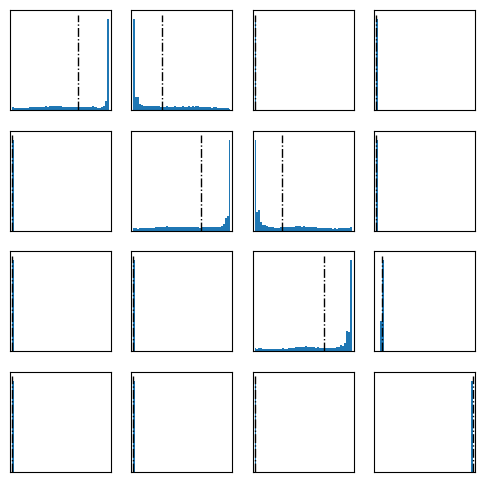

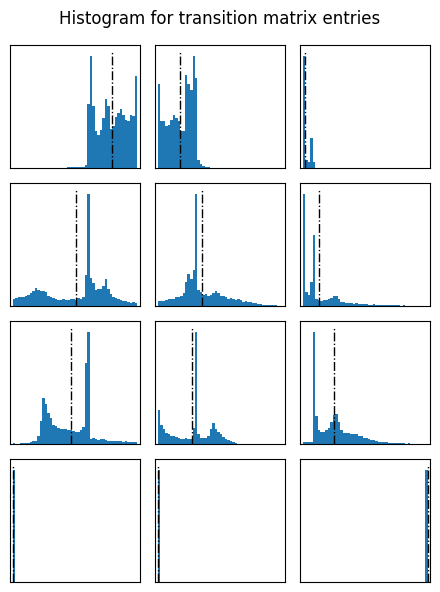

In [77]:
fig, axs = plt.subplots(n, n)
valid_indices = jnp.sum(jnp.isnan(T_arr), axis=(-1,-2)) == 0

print("Valid indices:", jnp.sum(valid_indices),"/",len(valid_indices))

bins = 10

T_mode = jnp.zeros_like(T)
O_mode = jnp.zeros_like(O)

fig.set_size_inches(1.5*n,1.5*n)
for i in range(n):
    for j in range(n):
        counts, bin_edges = jnp.histogram(T_arr[valid_indices, i, j], bins=bins)

        mode_idx = jnp.argmax(counts)
        mode_val = jnp.mean(bin_edges[mode_idx:mode_idx+2])

        T_mode = T_mode.at[i,j].set(mode_val)
        
        axs[i,j].hist(jnp.array(T_arr[valid_indices,i,j]), density=True, bins=50, range=(0.0,1.0))
        axs[i,j].set_xlim(-0.02,1.02)
        axs[i,j].vlines(jnp.mean(T_arr[valid_indices,i,j]), *axs[i,j].get_ylim(), "k", linewidth=1.0, linestyle="-.")
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
        # axs[i,j].set_ylim(0,4)
plt.show()
fig, axs = plt.subplots(n,m)
fig.set_size_inches(1.5*m,1.5*n)
for i in range(n):
    for j in range(m):
        counts, bin_edges = jnp.histogram(O_arr[valid_indices, i, j], bins=bins)

        mode_idx = jnp.argmax(counts)
        mode_val = jnp.mean(bin_edges[mode_idx:mode_idx+2])
        
        O_mode = O_mode.at[i,j].set(mode_val)

        axs[i,j].hist(jnp.array(O_arr[valid_indices,i,j]), density=True, bins=50, range=(0.0,1.0))
        axs[i,j].set_xlim(-0.02,1.02)
        axs[i,j].vlines(jnp.mean(O_arr[valid_indices,i,j]), *axs[i,j].get_ylim(), "k", linewidth=1.0, linestyle="-.")
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
        # axs[i,j].set_ylim(0,4)

fig.suptitle(f"Histogram for transition matrix entries")
plt.tight_layout()
plt.show()

T_mode = T_mode * T_structure
O_mode = O_mode * O_structure
T_mode = T_mode / jnp.sum(T_mode, axis=-1)[:, None]
O_mode = O_mode / jnp.sum(O_mode, axis=-1)[:, None]


T true:
 [[0.95 0.05 0.   0.  ]
 [0.   0.95 0.05 0.  ]
 [0.   0.   0.95 0.05]
 [0.   0.   0.   1.  ]]

T mean:
 [[0.697 0.303 0.    0.   ]
 [0.    0.713 0.287 0.   ]
 [0.    0.    0.921 0.079]
 [0.    0.    0.    1.   ]]

T weighted:
 [[0.654 0.346 0.    0.   ]
 [0.    0.521 0.479 0.   ]
 [0.    0.    0.89  0.11 ]
 [0.    0.    0.    1.   ]]

T mode:
 [[0.949 0.051 0.    0.   ]
 [0.    0.947 0.053 0.   ]
 [0.    0.    0.937 0.063]
 [0.    0.    0.    1.   ]]


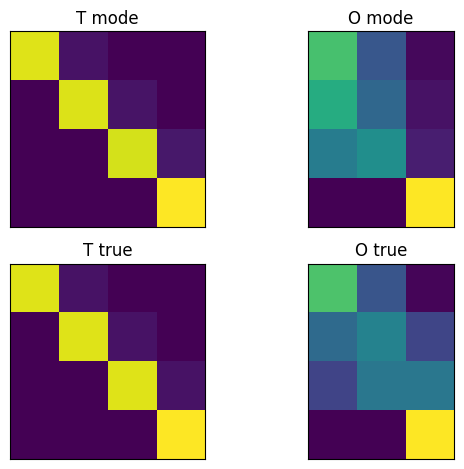

In [78]:
print("\nT true:\n", T)
print("\nT mean:\n", T_mean)
print("\nT weighted:\n", T_estimate)
print("\nT mode:\n", T_mode)

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(T_mode)
axs[0,1].imshow(O_mode)
axs[1,0].imshow(T)
axs[1,1].imshow(O)
axs[0,0].set_title("T mode")
axs[0,1].set_title("O mode")
axs[1,0].set_title("T true")
axs[1,1].set_title("O true")
for coord in ((0,0), (0,1), (1,0),(1,1)):
    axs[*coord].set_xticks([])
    axs[*coord].set_yticks([])
plt.tight_layout()
plt.show()

assert jnp.allclose(jnp.sum(T_estimate, axis=-1), 1)
assert jnp.allclose(jnp.sum(T_mean, axis=-1), 1)
assert jnp.allclose(jnp.sum(T_mode, axis=-1), 1)

In [79]:

true_llhood = jax.vmap(lambda _obs: log_likelihood(_obs, T, O, mu))(observations)
print("Log likelihood of training sequences, true params:\t", logsumexp(true_llhood))

mean_llhood = jax.vmap(lambda _obs: log_likelihood(_obs, T_mean, O_mean, mu))(observations)
print("Log likelihood of training sequences, mean params:\t", logsumexp(mean_llhood))

estimated_llhood = jax.vmap(lambda _obs: log_likelihood(_obs, T_estimate, O_estimate, mu))(observations)
print("Log likelihood of training sequences, weighted params:\t", logsumexp(estimated_llhood))

mode_llhood = jax.vmap(lambda _obs: log_likelihood(_obs, T_mode, O_mode, mu))(observations)
print("Log likelihood of training sequences, mode params:\t", logsumexp(mode_llhood))

Log likelihood of training sequences, true params:	 -6.5327457369540305
Log likelihood of training sequences, mean params:	 -3.557044932673599
Log likelihood of training sequences, weighted params:	 -2.9813015654454946
Log likelihood of training sequences, mode params:	 -6.334025175268854


Mean parameters


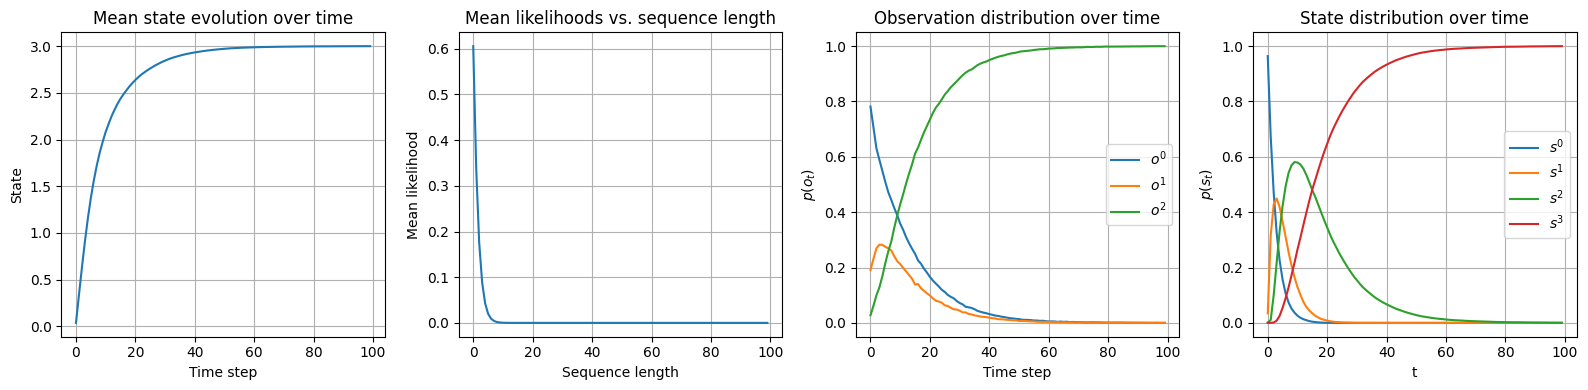

In [80]:
print("Mean parameters")
states_approx, obs_approx = jax.vmap(lambda _key: generate_sequence(_key, T_mean, O_mean, mu, len_sequence))(jnp.array(split(key(0), 20_000)))
plot_stats(states_approx, obs_approx)

Histogram mode parameters


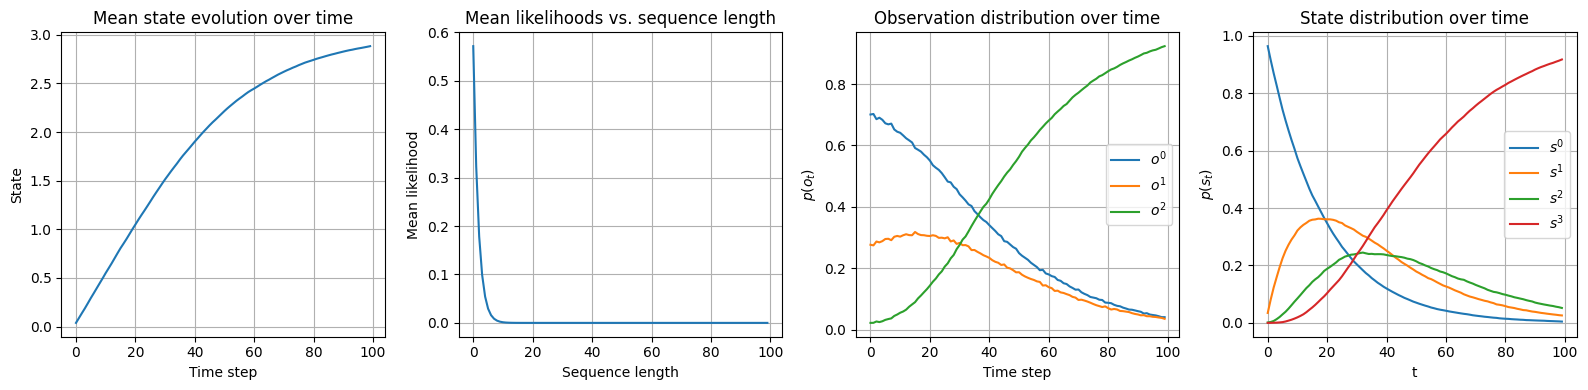

In [81]:
print("Histogram mode parameters")
states_approx, obs_approx = jax.vmap(lambda _key: generate_sequence(_key, T_mode, O_mode, mu, len_sequence))(jnp.array(split(key(0), 20_000)))
plot_stats(states_approx, obs_approx)

True parameters


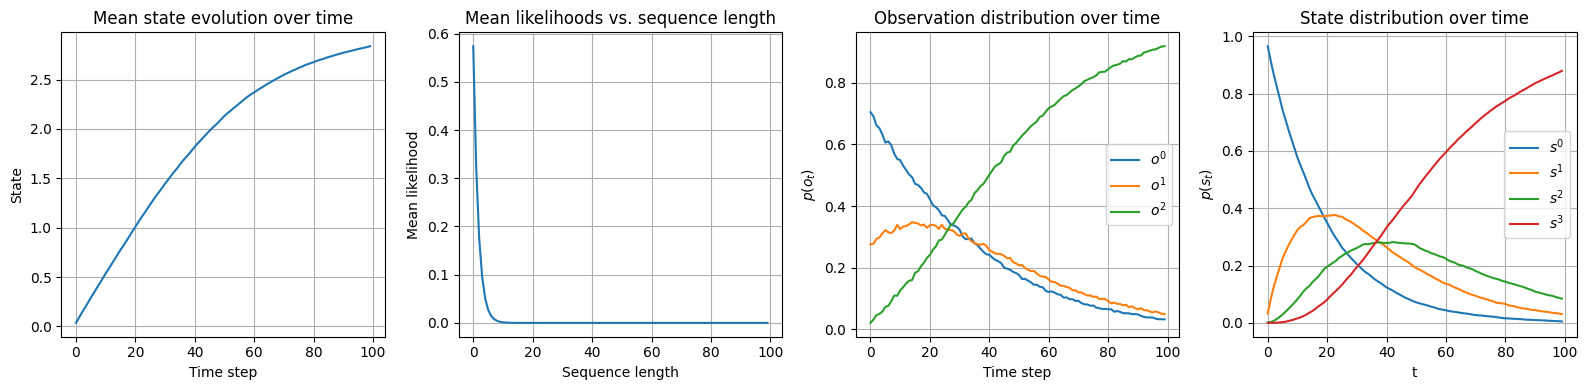

In [69]:
print("True parameters")
plot_stats(states, observations)